### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import langid
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import ast

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [12]:
def summary_df(df):
    # Print the shape of the dataset
    print(f"Dataset Shape: {df.shape}")

    # Create a summary dataframe with dtypes and name of columns
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]

    # Calculate the number of missing values
    summary['Missing'] = df.isnull().sum().values

    # Calculate the number of unique values
    summary['Uniques'] = df.nunique().values

    # Initialize columns for summary statistics
    summary['Mean'] = None
    summary['Median'] = None
    summary['Min'] = None
    summary['25%'] = None
    summary['50%'] = None
    summary['75%'] = None
    summary['Max'] = None
    summary['Std'] = None

    # Compute statistics for numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    summary.loc[summary['Name'].isin(
        num_cols), 'Mean'] = df[num_cols].mean().values
    summary.loc[summary['Name'].isin(
        num_cols), 'Median'] = df[num_cols].median().values
    summary.loc[summary['Name'].isin(
        num_cols), 'Min'] = df[num_cols].min().values
    summary.loc[summary['Name'].isin(
        num_cols), '25%'] = df[num_cols].quantile(0.25).values
    summary.loc[summary['Name'].isin(
        num_cols), '50%'] = df[num_cols].median().values
    summary.loc[summary['Name'].isin(
        num_cols), '75%'] = df[num_cols].quantile(0.75).values
    summary.loc[summary['Name'].isin(
        num_cols), 'Max'] = df[num_cols].max().values
    summary.loc[summary['Name'].isin(
        num_cols), 'Std'] = df[num_cols].std().values

    return summary

In [13]:
import os

# Append '/scraped_reviews' to the current directory
new_dir = os.path.join(os.getcwd(), 'Web Scraping')
os.chdir(new_dir)

# Verify the updated working directory
print("Updated Working Directory:", os.getcwd())

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\ong_z\\OneDrive\\Desktop\\BT5153\\Group Project\\Web Scraping\\Web Scraping'

In [48]:
# Load your CSV
property_df = pd.read_csv('property_df.csv')
reviews_df = pd.read_csv("booking_reviews_clean.csv", encoding="utf-8")
reviews_df.drop(columns=['detected_lang_title', 'detected_lang_pos', 'detected_lang_neg', 'removal_reason'], inplace=True)

### 1. Hotels

In [6]:
summary_df(property_df)

Dataset Shape: (444, 30)


,Name,dtypes,Missing,Uniques,Mean,Median,Min,25%,50%,75%,Max,Std
0,hotel_name,object,0,444,None,None,None,None,None,None,None,None
1,hotel_url,object,0,444,None,None,None,None,None,None,None,None
2,original_price,float64,186,160,236.368217,194.0,53.0,137.25,194.0,270.0,1328.0,165.381366
3,current_price,int64,0,249,232.822072,168.0,48.0,118.75,168.0,270.0,2374.0,219.070203
4,num_reviews,float64,10,380,1220.396313,616.5,1.0,190.25,616.5,1655.0,18300.0,1698.185849
5,review_score,float64,10,58,7.471198,7.7,1.0,6.9,7.7,8.3,9.6,1.186403
6,review_label,object,10,6,None,None,None,None,None,None,None,None
7,star_rating,float64,49,5,3.38481,3.0,1.0,3.0,3.0,4.0,5.0,1.132704
8,preferred_partner,object,0,2,None,None,None,None,None,None,None,None
9,sustainability_certified,object,0,2,None,None,None,None,None,None,None,None


<Axes: xlabel='price_tier'>

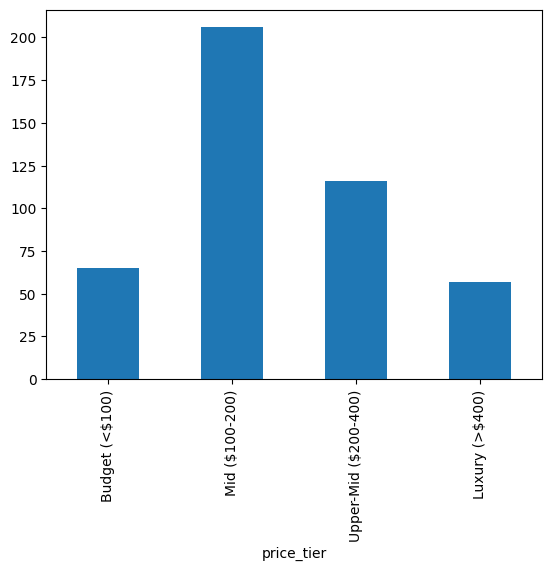

In [25]:
# --------------------------
# SEGMENT HOTELS BY PRICE TIER
# --------------------------

# Add price tier bins to property_df
price_labels = ['Budget (<$100)', 'Mid ($100-200)', 'Upper-Mid ($200-400)', 'Luxury (>$400)']
property_df['price_tier'] = pd.cut(
    property_df['current_price'],
    bins=[0, 100, 200, 400, float('inf')],
    labels=price_labels
)

# Convert price tier to ordered categorical
property_df['price_tier'] = property_df['price_tier'].astype(
    pd.CategoricalDtype(categories=price_labels, ordered=True)
)

property_df['price_tier'].value_counts(sort=False).plot(kind='bar')

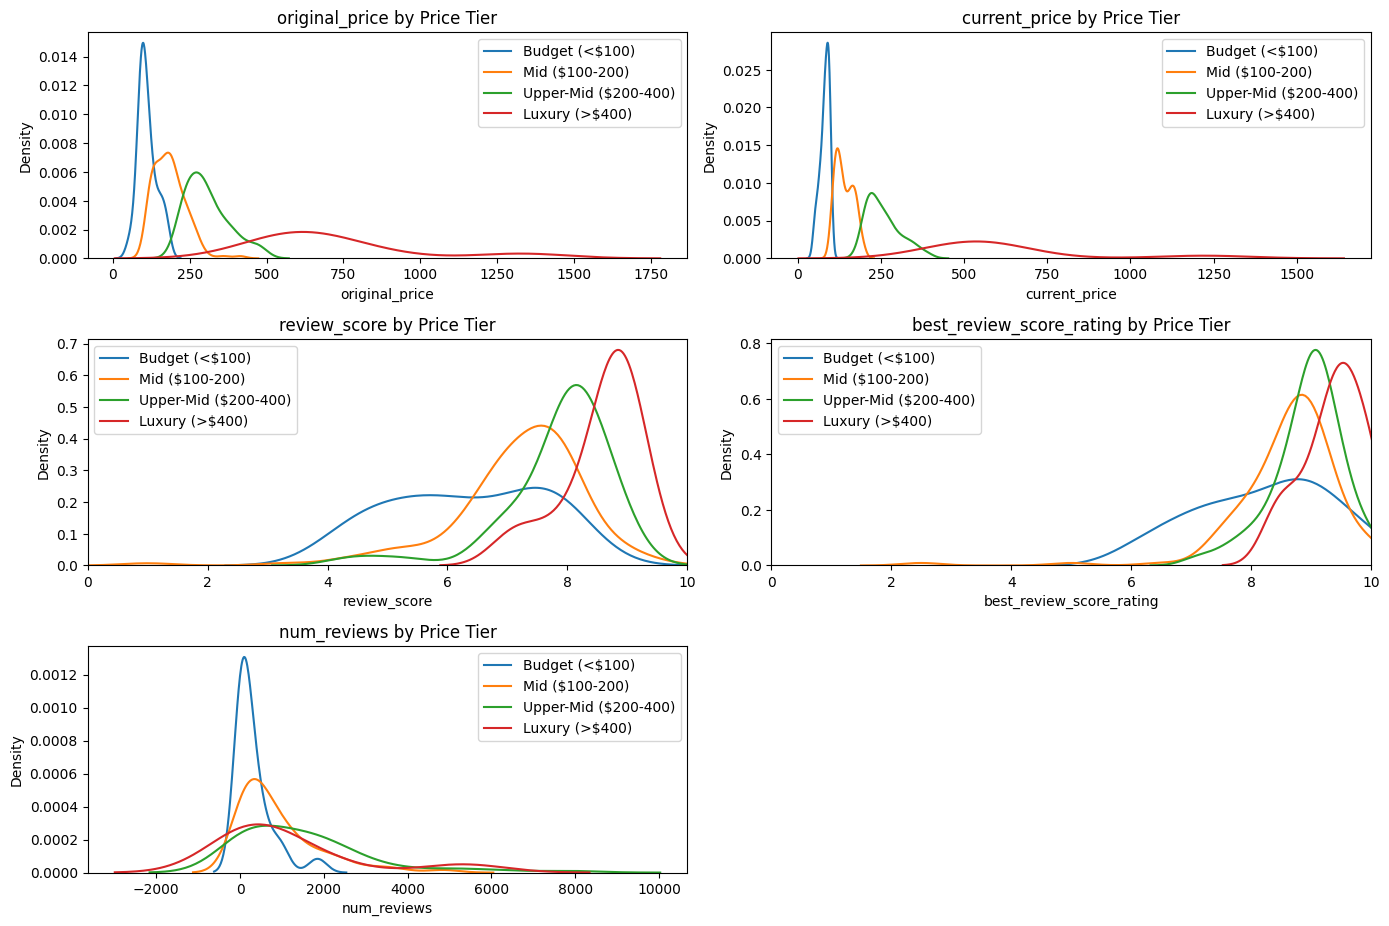

In [26]:
# --------------------------
# NUMERIC VARIABLES
# --------------------------

# Filter only rows with no missing numeric values
numeric_cols = ['original_price', 'current_price', 'review_score', 'best_review_score_rating', 'num_reviews']
numeric_df = property_df.dropna(subset=numeric_cols + ['price_tier'])

# Plot histograms of numeric variables, separated by price_tier
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# Plot KDE plots by price tier for each numeric column
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    for label in price_labels:
        subset = numeric_df[numeric_df['price_tier'] == label]
        sns.kdeplot(subset[col], ax=ax, label=label)
    ax.set_title(f"{col} by Price Tier")
    if col in ["review_score", "best_review_score_rating"]:
        ax.set_xlim(0, 10)
    ax.legend()

# Hide any unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

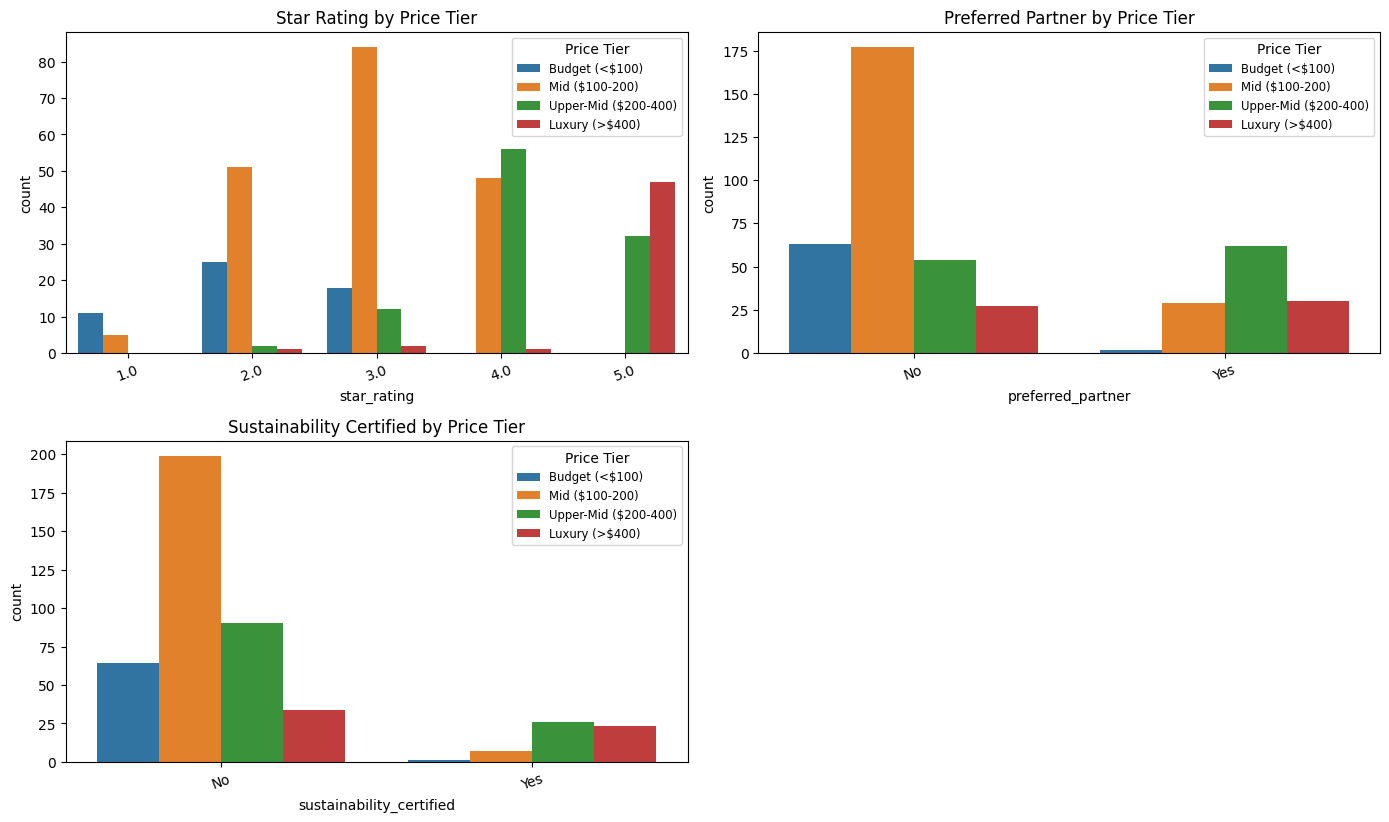

In [27]:
# --------------------------
# CATEGORICAL VARIABLES
# --------------------------

categorical_cols = ['star_rating', 'preferred_partner', 'sustainability_certified']

# Create subplot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Barplots for each categorical column split by price tier
for i, col in enumerate(categorical_cols):
    df_cat = (
        property_df
        .dropna(subset=[col, 'price_tier'])
        .groupby(['price_tier', col])
        .size()
        .reset_index(name='count')
    )

    sns.barplot(data=df_cat, x=col, y='count', hue='price_tier', ax=axes[i], palette='tab10')
    axes[i].set_title(f"{col.replace('_', ' ').title()} by Price Tier")
    axes[i].tick_params(axis='x', rotation=20)
    axes[i].legend(title="Price Tier", fontsize='small', loc='best')

# Hide unused axes if any
for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



In [28]:
# --------------------------
# GEOGRAPHIC VISUALIZATION
# --------------------------

# Drop rows missing lat/lon for mapping
property_geo = property_df.dropna(subset=['latitude', 'longitude', 'current_price', 'review_score', 'price_tier'])

# Segmentation by review score bands
score_bins = [0, 6, 7.5, 8.5, 10]
score_labels = ['Low (<6)', 'OK (6-7.5)', 'Good (7.5-8.5)', 'Excellent (>8.5)']
property_geo['review_tier'] = pd.cut(property_geo['review_score'], bins=score_bins, labels=score_labels)

# Create a concise summary table
segment_summary = property_geo.groupby(['price_tier', 'review_tier']).agg(
    hotel_count=('hotel_name', 'count'),
    avg_price=('current_price', 'mean'),
    avg_score=('review_score', 'mean')
).reset_index()

# Create interactive map
fig = px.scatter_mapbox(
    property_geo,
    lat="latitude",
    lon="longitude",
    hover_name="hotel_name",
    hover_data=["current_price", "review_score", "price_tier", "review_tier"],
    color="price_tier",
    zoom=11,
    height=600,
    mapbox_style="carto-positron",
    title="Hotel Locations in Singapore by Price Tier"
)
fig.show()


C:\Users\ong_z\AppData\Local\Temp\ipykernel_28548\428989088.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
# --------------------------
# FACILITIES ANALYSIS
# --------------------------

# Parse facilities JSON-like text
def parse_facilities(s):
    try:
        return ast.literal_eval(s)
    except:
        return {}

# Extract 'Most popular facilities' only
def extract_popular_facilities(facility_dict):
    return list(set(facility_dict.get('Most popular facilities', [])))  

# Apply parsing and extraction
property_df['parsed_facilities'] = property_df['facilities'].apply(parse_facilities)
property_df['popular_facilities'] = property_df['parsed_facilities'].apply(extract_popular_facilities)

# Flatten into long-format records
popular_records = [
    {'price_tier': row['price_tier'], 'amenity': amenity.strip()}
    for _, row in property_df.iterrows()
    for amenity in row['popular_facilities']
]

popular_df = pd.DataFrame(popular_records)

# Total number of hotels per tier for percentage calculation
total_by_tier = property_df['price_tier'].value_counts().to_dict()

# Count occurrences and compute % of hotels in tier
popular_counts = (
    popular_df
    .groupby(['price_tier', 'amenity'])
    .size()
    .reset_index(name='count')
)
popular_counts['percent'] = popular_counts.apply(
    lambda row: 100 * row['count'] / total_by_tier[row['price_tier']], axis=1
)

# Focus on top n amenities overall
n=25
top_amenities = (
    popular_df['amenity']
    .value_counts()
    .nlargest(n)
    .index
    .tolist()
)
popular_filtered = popular_counts[popular_counts['amenity'].isin(top_amenities)]
popular_filtered['price_tier'] = popular_filtered['price_tier'].astype(
    pd.CategoricalDtype(categories=price_labels, ordered=True)
)

# Plot
# plt.figure(figsize=(12, 8))
# sns.barplot(
#     data=popular_filtered,
#     y='amenity',
#     x='percent',
#     hue='price_tier',
#     palette='tab10',

# )
# plt.title(f"Top {n} 'Most Popular Facilities' by Hotel Price Tier (% of Hotels)")
# plt.xlabel("% of Hotels")
# plt.ylabel("Amenity")
# plt.legend(title="Price Tier")
# plt.tight_layout()
# plt.show()


C:\Users\ong_z\AppData\Local\Temp\ipykernel_28548\2777332369.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



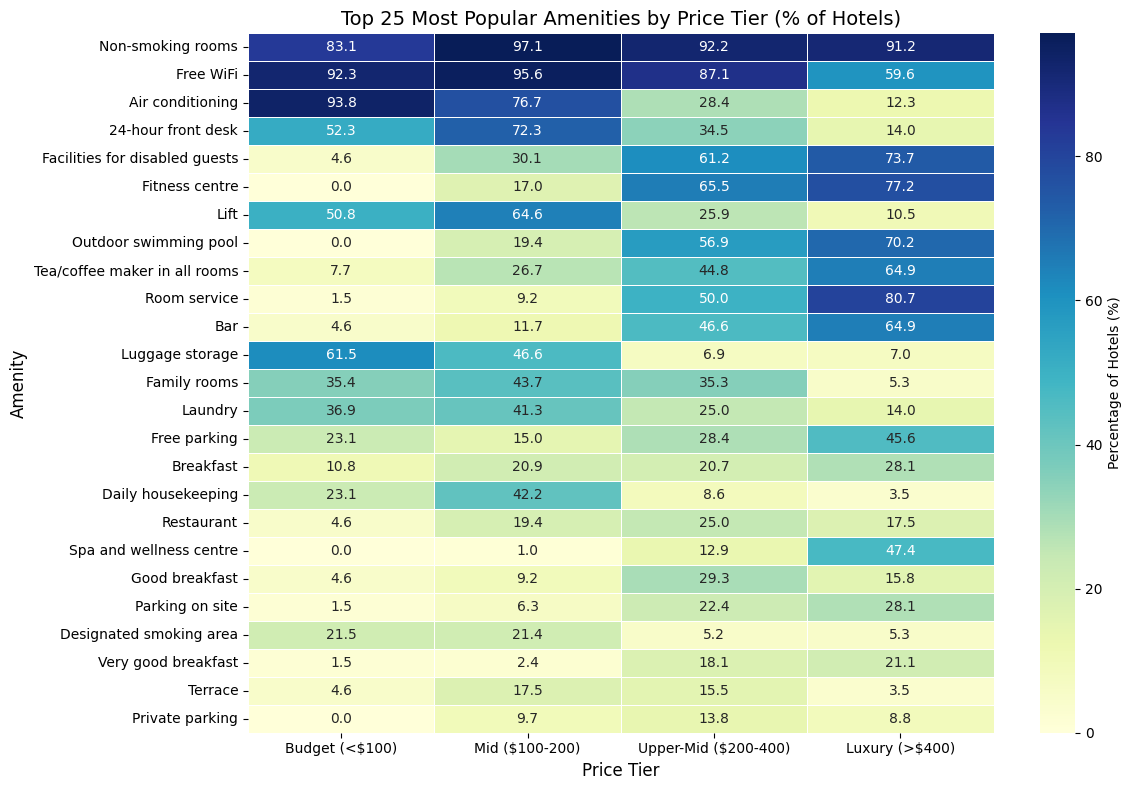

In [56]:
# Prepare heatmap data
heatmap_df = popular_filtered.pivot(index='amenity', columns='price_tier', values='percent').fillna(0)

# Sort amenities by their total percentage across all price tiers for better readability
heatmap_df['Total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".1f",  # Show percentages with one decimal place
    cmap='YlGnBu',
    linewidths=.5,
    cbar_kws={'label': 'Percentage of Hotels (%)'}
)
plt.title(f"Top {n} Most Popular Amenities by Price Tier (% of Hotels)", fontsize=14)
plt.xlabel("Price Tier", fontsize=12)
plt.ylabel("Amenity", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)  # Keep y-axis labels horizontal for readability
plt.tight_layout()
plt.show()

### 2. Reviews

In [49]:
summary_df(reviews_df)

Dataset Shape: (185125, 12)


,Name,dtypes,Missing,Uniques,Mean,Median,Min,25%,50%,75%,Max,Std
0,review_ID,int64,0,185125,92563.0,92563.0,1.0,46282.0,92563.0,138844.0,185125.0,53441.128629
1,reviewer_name,object,38,40322,None,None,None,None,None,None,None,None
2,reviewer_country,object,208,215,None,None,None,None,None,None,None,None
3,review_room_name,object,0,1688,None,None,None,None,None,None,None,None
4,review_num_nights,int64,0,43,2.804775,2.0,0.0,1.0,2.0,4.0,60.0,2.135916
5,review_stay_date,object,0,41,None,None,None,None,None,None,None,None
6,review_traveler_type,object,13,4,None,None,None,None,None,None,None,None
7,review_score,float64,0,25,7.780228,8.0,1.0,7.0,8.0,9.0,10.0,2.162127
8,review_title,object,4263,88438,None,None,None,None,None,None,None,None
9,review_positive_text,object,33283,134808,None,None,None,None,None,None,None,None


In [50]:
print(reviews_df.columns)  # Verify column names

Index(['review_ID', 'reviewer_name', 'reviewer_country', 'review_room_name',
       'review_num_nights', 'review_stay_date', 'review_traveler_type',
       'review_score', 'review_title', 'review_positive_text',
       'review_negative_text', 'hotel_name'],
      dtype='object')


C:\Users\ong_z\AppData\Local\Temp\ipykernel_27232\2288309109.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, y='Country', x='Review Count', palette='Blues_d')


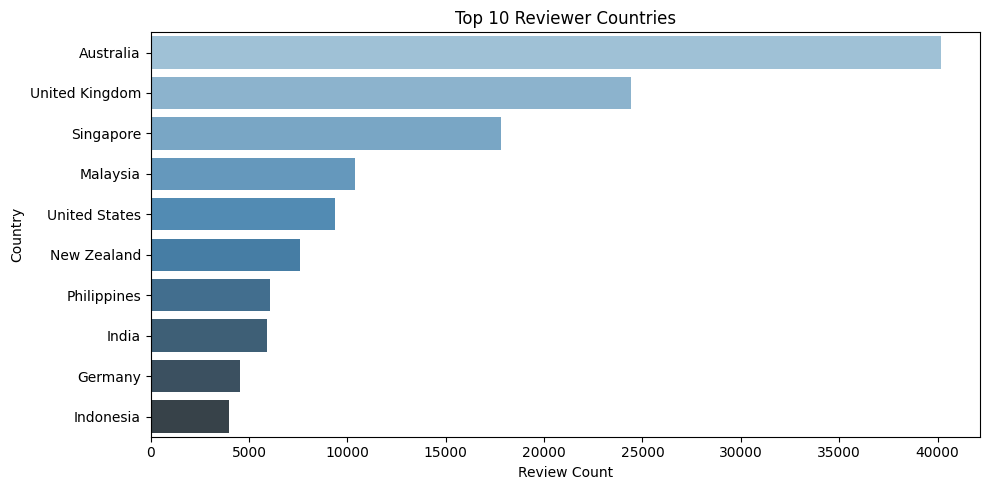

C:\Users\ong_z\AppData\Local\Temp\ipykernel_27232\2288309109.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traveler_type_dist, y='Traveler Type', x='Count', palette='Greens_d')


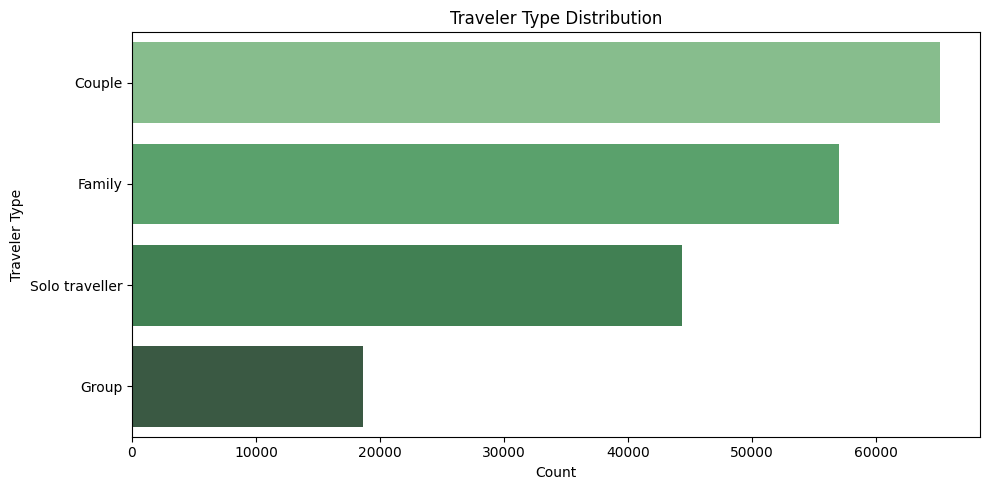

In [51]:
# --- 1. Top Reviewer Countries ---
top_countries = (
    reviews_df['reviewer_country']
    .value_counts()
    .nlargest(10)
    .reset_index()
)
top_countries.columns = ['Country', 'Review Count']


# --- 2. Traveler Type Distribution ---
traveler_type_dist = (
    reviews_df['review_traveler_type']
    .value_counts()
    .reset_index()
)
traveler_type_dist.columns = ['Traveler Type', 'Count']


# Plot Top Countries
plt.figure(figsize=(10, 5))
sns.barplot(data=top_countries, y='Country', x='Review Count', palette='Blues_d')
plt.title("Top 10 Reviewer Countries")
plt.tight_layout()
plt.show()

# Plot Traveler Type Distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=traveler_type_dist, y='Traveler Type', x='Count', palette='Greens_d')
plt.title("Traveler Type Distribution")
plt.tight_layout()
plt.show()


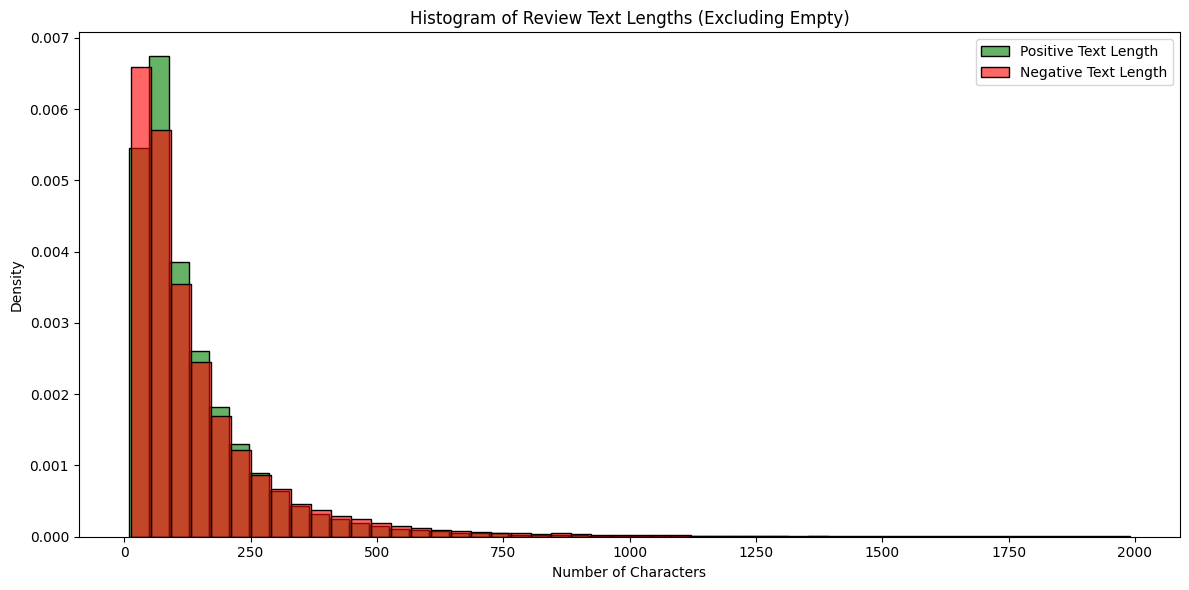

In [56]:
# --------------------------
# REVIEWS TEXT
# --------------------------

# Recompute character counts to ensure freshness after reset
reviews_df['pos_len'] = reviews_df['review_positive_text'].fillna('').str.len()
reviews_df['neg_len'] = reviews_df['review_negative_text'].fillna('').str.len()

# Filter each length column individually for non-zero entries
pos_nonzero = reviews_df[reviews_df['pos_len'] > 0]['pos_len']
neg_nonzero = reviews_df[reviews_df['neg_len'] > 0]['neg_len']

# Plot histograms
plt.figure(figsize=(12, 6))
sns.histplot(pos_nonzero, bins=50, color='green', label='Positive Text Length', kde=False, stat='density', alpha=0.6)
sns.histplot(neg_nonzero, bins=50, color='red', label='Negative Text Length', kde=False, stat='density', alpha=0.6)
plt.legend()
plt.title("Histogram of Review Text Lengths (Excluding Empty)")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [57]:
# Calculate mean and median only on non-empty reviews
pos_stats = pos_nonzero.describe()[['mean', '50%']].rename({'50%': 'median'})
neg_stats = neg_nonzero.describe()[['mean', '50%']].rename({'50%': 'median'})

# Combine into summary DataFrame
length_summary = pd.DataFrame({
    'Positive Reviews': pos_stats,
    'Negative Reviews': neg_stats
})

length_summary


,Positive Reviews,Negative Reviews
mean,139.390544,156.200855
median,92.000000,97.000000


In [58]:
# Clean review text
pos_texts = reviews_df['review_positive_text'].dropna().str.lower()
neg_texts = reviews_df['review_negative_text'].dropna().str.lower()

# Function to get top n-grams
def get_top_ngrams(corpus, ngram_range=(1, 1), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return sorted_words[:top_k]

# Extract n-grams
top_pos_unigrams = get_top_ngrams(pos_texts, (1, 1))
top_pos_bigrams = get_top_ngrams(pos_texts, (2, 2))
top_pos_trigrams = get_top_ngrams(pos_texts, (3, 3))

top_neg_unigrams = get_top_ngrams(neg_texts, (1, 1))
top_neg_bigrams = get_top_ngrams(neg_texts, (2, 2))
top_neg_trigrams = get_top_ngrams(neg_texts, (3, 3))

# Assemble into DataFrame
ngrams_summary = pd.DataFrame({
    "Positive Unigrams": [w for w, _ in top_pos_unigrams],
    "Negative Unigrams": [w for w, _ in top_neg_unigrams],
    "Positive Bigrams": [w for w, _ in top_pos_bigrams],
    "Negative Bigrams": [w for w, _ in top_neg_bigrams],
    "Positive Trigrams": [w for w, _ in top_pos_trigrams],
    "Negative Trigrams": [w for w, _ in top_neg_trigrams],
})

ngrams_summary


,Positive Unigrams,Negative Unigrams,Positive Bigrams,Negative Bigrams,Positive Trigrams,Negative Trigrams
0,location,room,great location,room small,staff friendly helpful,room bit small
1,staff,hotel,good location,small room,friendly helpful staff,room quite small
2,room,small,staff friendly,room service,good value money,room little small
3,good,breakfast,friendly helpful,booking com,great location close,room size small
4,great,rooms,friendly staff,rooms small,location friendly staff,rooms bit small
5,hotel,staff,location good,bit small,location close mrt,red light district
6,clean,bathroom,location great,hot water,marina bay sands,hot water shower
7,friendly,bit,walking distance,room bit,location walking distance,rooms quite small
8,nice,bed,room clean,didnt like,staff helpful friendly,took long time
9,breakfast,shower,mrt station,air conditioning,close mrt station,little bit small


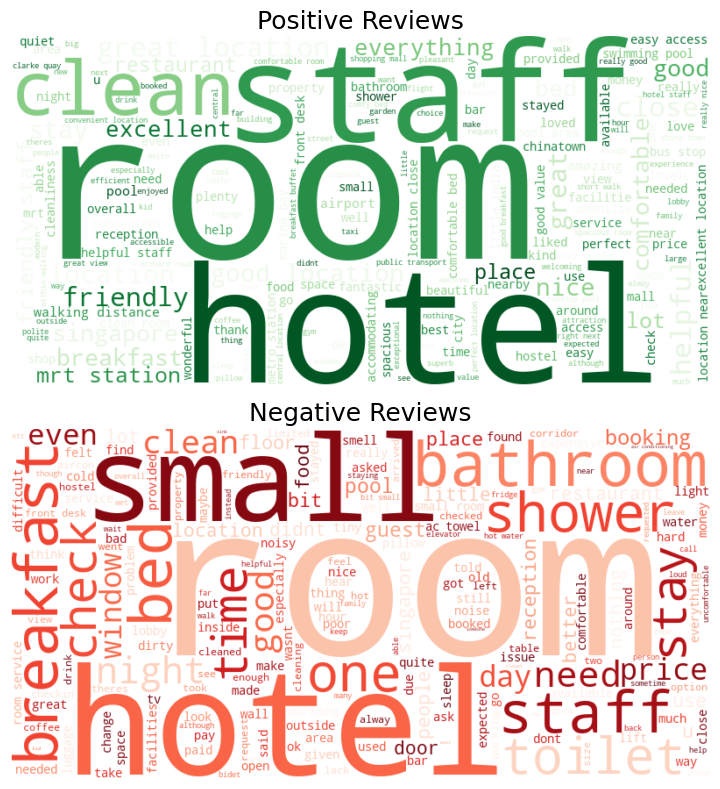

In [62]:
from wordcloud import WordCloud, STOPWORDS

# Join all text into a single string
pos_text_corpus = " ".join(pos_texts.astype(str))
neg_text_corpus = " ".join(neg_texts.astype(str))

# Add custom stopwords if needed
stopwords = set(STOPWORDS)

# Generate word clouds
wordcloud_pos = WordCloud(
    background_color='white',
    width=800,
    height=400,
    stopwords=stopwords,
    colormap='Greens'
).generate(pos_text_corpus)

wordcloud_neg = WordCloud(
    background_color='white',
    width=800,
    height=400,
    stopwords=stopwords,
    colormap='Reds'
).generate(neg_text_corpus)

# Plot them side-by-side
fig, axes = plt.subplots(2, 1, figsize=(18, 8))
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title("Positive Reviews", fontsize=18)
axes[0].axis('off')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title("Negative Reviews", fontsize=18)
axes[1].axis('off')

plt.tight_layout()
plt.show()
